In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import random

# for easier reading np
np.set_printoptions(precision=3,suppress=True)

# Data

In [7]:
# Prepare the data
def to1hot(labels):
    """Converts an array of class labels into their 1hot encodings.
    Assumes that there are at most 3 classes."""
    return torch.eye(3)[labels]

class Dataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.X)

from google.colab import drive
drive.mount('/content/drive')
data = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/data/iris.csv', dtype='f4', delimiter=',')
X, y = data[:, :-1], data[:, -1] - 1

# Split into train/test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

# Normalize features
mu = X_train.mean(0, keepdims=True)
std = X_train.std(0, keepdims=True)
X_train = (X_train - mu) / std
X_test = (X_test - mu) / std

db_train = Dataset(X_train, y_train)
db_test = Dataset(X_test, y_test)
print(len(db_train), db_train[0])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
120 (array([-0.554,  1.476, -1.287, -1.329], dtype=float32), 0.0)


X_batch torch.Size([50, 4])
y_batch torch.Size([50])


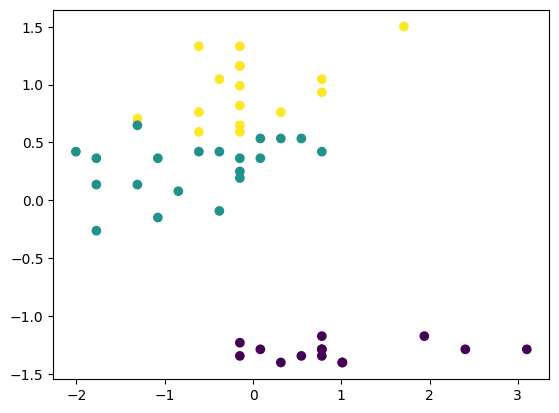

In [8]:
# Reading the dataset
def data_iter(batch_size, db):
    num_examples = len(db)

    # The examples are read at random, in no particular order
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        X, Y = [], []
        for j in indices[i:i + batch_size]:
            x, lbl = db[j]

            # Process image
            x = torch.from_numpy(x).float()
            lbl = torch.tensor(lbl).long()

            X.append(x), Y.append(lbl)
        yield torch.stack(X), torch.stack(Y)

# Check data reader
for X_batch, y_batch in data_iter(batch_size=50, db=db_train):
    print('X_batch', X_batch.shape)
    print('y_batch', y_batch.shape)
    plt.scatter(X_batch[:, 1].numpy(), X_batch[:, 2].numpy(), c=y_batch.numpy())
    break

# Model

In [18]:
# Define Model
from torch import nn

class DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=30, num_classes=3, num_layers=6):
        super(DNN, self).__init__()

        # Define layers
        layers = [nn.Linear(input_dim, hidden_dim)]
        for i in range(1, num_layers-1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, num_classes))
        self.layers = nn.ModuleList(layers)
        self.relu = nn.ReLU()

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.01)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) - 1:
                x = self.relu(layer(x))
            else:
                # Do not apply relu to the last layer
                x = layer(x)
        return x

class Residual_DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=30, num_classes=3, num_layers=6):
        super(Residual_DNN, self).__init__()

        # Define layers
        layers = [nn.Linear(input_dim, hidden_dim)]
        for i in range(1, num_layers-1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, num_classes))
        self.layers = nn.ModuleList(layers)
        self.relu = nn.ReLU()

        # For matching the dimensions in the first residual connection (if input_dim != hidden_dim)
        self.match_dim = nn.Linear(input_dim, hidden_dim)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.01)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if i == 0 and x.shape[1] != self.layers[0].weight.shape[0]: # if input_dim != hidden_dim
                residual = self.match_dim(x)
            else:
                residual = x

            if i < len(self.layers) - 1:
                x = residual + self.relu(layer(x))
            else:
                # Do not apply relu to the last layer
                x = layer(x)
        return x

# Check model
model = DNN(input_dim=4, num_classes=3, hidden_dim=30, num_layers=2)
for X_batch, y_batch in data_iter(batch_size=8, db=db_train):
    print('X_batch', X_batch.shape)
    out_batch = model(X_batch)
    print('out_batch', out_batch.shape, out_batch)
    break

def train_model(model, num_epochs=200):
    cross_entropy = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    accuracy = lambda y_hat, y: (y_hat.argmax(dim=1) == y).float().mean()

    all_losses, all_accuracies = [], []
    for epoch in range(num_epochs):
        losses = []
        for X_batch, y_batch in data_iter(batch_size=batch_size, db=db_train):
            yhat = model(X_batch)
            l = cross_entropy(yhat, y_batch)
            l.backward()
            opt.step()
            opt.zero_grad()
            losses.append(l.detach().item())
        acc = []
        for X_batch, y_batch in data_iter(batch_size=16, db=db_test):
            yhat = model(X_batch)
            acc.append(accuracy(yhat, y_batch))
        all_losses.append(np.mean(losses))
        all_accuracies.append(np.mean(acc))
    return np.mean(all_accuracies[-10:])

depths = [2, 3, 4, 5, 10, 20, 50, 100]
results = []

for depth in depths:
    model = Residual_DNN(input_dim=4, num_classes=3, hidden_dim=30, num_layers=depth)
    acc = train_model(model)
    results.append((depth, acc))
    print(f"Depth: {depth}, Test Accuracy: {acc:.3f}")

X_batch torch.Size([8, 4])
out_batch torch.Size([8, 3]) tensor([[ 0.1219,  0.1620, -0.1693],
        [ 0.1217,  0.1607, -0.1694],
        [ 0.1218,  0.1607, -0.1697],
        [ 0.1211,  0.1615, -0.1695],
        [ 0.1222,  0.1605, -0.1692],
        [ 0.1217,  0.1613, -0.1691],
        [ 0.1220,  0.1608, -0.1693],
        [ 0.1214,  0.1626, -0.1694]], grad_fn=<AddmmBackward0>)
Depth: 2, Test Accuracy: 0.989
Depth: 3, Test Accuracy: 0.967
Depth: 4, Test Accuracy: 0.966
Depth: 5, Test Accuracy: 0.956
Depth: 10, Test Accuracy: 0.967
Depth: 20, Test Accuracy: 0.899
Depth: 50, Test Accuracy: 0.336
Depth: 100, Test Accuracy: 0.918


# Training

Start training
Epoch 10: Train Loss 0.213 Test Accuracy 0.902
Epoch 20: Train Loss 0.086 Test Accuracy 0.933
Epoch 30: Train Loss 0.064 Test Accuracy 0.964
Epoch 40: Train Loss 0.057 Test Accuracy 0.933
Epoch 50: Train Loss 0.052 Test Accuracy 1.000
Epoch 60: Train Loss 0.054 Test Accuracy 1.000
Epoch 70: Train Loss 0.045 Test Accuracy 1.000
Epoch 80: Train Loss 0.047 Test Accuracy 1.000
Epoch 90: Train Loss 0.045 Test Accuracy 0.964
Epoch 100: Train Loss 0.047 Test Accuracy 0.969
Epoch 110: Train Loss 0.075 Test Accuracy 1.000
Epoch 120: Train Loss 0.045 Test Accuracy 0.969
Epoch 130: Train Loss 0.042 Test Accuracy 0.964
Epoch 140: Train Loss 0.041 Test Accuracy 0.964
Epoch 150: Train Loss 0.038 Test Accuracy 0.969
Epoch 160: Train Loss 0.047 Test Accuracy 0.964
Epoch 170: Train Loss 0.039 Test Accuracy 0.969
Epoch 180: Train Loss 0.044 Test Accuracy 0.964
Epoch 190: Train Loss 0.040 Test Accuracy 0.964
Epoch 200: Train Loss 0.036 Test Accuracy 0.969

Start evaluation
CM = 
 [[10.  0.

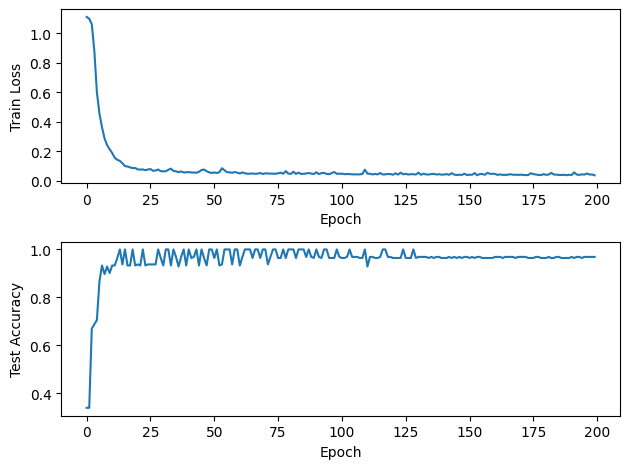

In [14]:
# Training
lr = 0.03
batch_size = 16
num_epochs = 200

model = DNN(input_dim=4, num_classes=3, hidden_dim=30, num_layers=2)
cross_entropy = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
accuracy = lambda y_hat, y: (y_hat.argmax(dim=1) == y).float().mean()

print("Start training")
all_losses, all_accuracies = [], []
for epoch in range(num_epochs):
    # Train for one epoch
    losses = []
    for X_batch, y_batch in data_iter(batch_size=batch_size, db=db_train):
        # Use model to compute predictions
        yhat = model(X_batch)
        l = cross_entropy(yhat, y_batch)  # Minibatch loss in `X_batch` and `y_batch`

        # Compute gradients by back propagation
        l.backward()

        # Update parameters using their gradient
        opt.step()
        opt.zero_grad()
        losses.append(l.detach().item())

    # Measure accuracy on the test set
    acc = []
    for X_batch, y_batch in data_iter(batch_size=16, db=db_test):
        yhat = model(X_batch)
        acc.append(accuracy(yhat, y_batch))

    all_losses.append(np.mean(losses))
    all_accuracies.append(np.mean(acc))

    if (epoch+1) % 10 == 0:
        # print(yhat)
        print(f"Epoch {epoch+1}: Train Loss {np.mean(losses):.3f} Test Accuracy {np.mean(acc):.3f}", flush=True)

# Evaluation
print("\nStart evaluation")
with torch.no_grad():
    yhat, y = [], []
    for X_batch, y_batch in data_iter(batch_size=16, db=db_test):
        yhat.append(model(X_batch))
        y.append(y_batch)

yhat = torch.cat(yhat, dim=0).argmax(dim=1)
y = torch.cat(y, dim=0)
cm = to1hot(y).T@to1hot(yhat)
print('CM = \n', cm.numpy())

plt.subplot(2, 1, 1)
plt.plot(all_losses)
plt.ylabel('Train Loss');
plt.xlabel('Epoch');
plt.subplot(2, 1, 2)
plt.plot(all_accuracies)
plt.ylabel('Test Accuracy');
plt.xlabel('Epoch');
plt.tight_layout()
plt.show()

a. It seems to be converging at a test accuracy of ~0.96, after 140 epochs

b. Vanishing gradient problem, occurs because the gradients become too small for the optimizer to adjust the weights

c. Yes, they can have a residual connection because the input/output dimensions for all layers are the same.

d. The residual connections allow gradients to skip layers, preventing the vanishing gradient proble. You do observe that the test accuracy isn't necessarily better with more layers though.